In [24]:
from pathlib import Path
from tqdm import tqdm
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, KBinsDiscretizer
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import joblib

base_path = Path("../datasets")
models_path = Path("../models")

df_file = base_path / "customer_churn.csv"

# Verifica se o arquivo existe e carrega o DataFrame
if df_file.exists():
    df_orig = pd.read_csv(df_file)
    display(df_orig.head())
    display(df_orig.shape)
else:
    print(f"Arquivo não encontrado: {df_file.resolve()}")

,Names,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Onboard_date,Location,Company,Churn
0,Cameron Williams,42.0,11066.80,0,7.22,8.0,2013-08-30 07:00:40,"10265 Elizabeth Mission Barkerburgh, AK 89518",Harvey LLC,1
1,Kevin Mueller,41.0,11916.22,0,6.50,11.0,2013-08-13 00:38:46,"6157 Frank Gardens Suite 019 Carloshaven, RI 1...",Wilson PLC,1
2,Eric Lozano,38.0,12884.75,0,6.67,12.0,2016-06-29 06:20:07,"1331 Keith Court Alyssahaven, DE 90114","Miller, Johnson and Wallace",1
3,Phillip White,42.0,8010.76,0,6.71,10.0,2014-04-22 12:43:12,"13120 Daniel Mount Angelabury, WY 30645-4695",Smith Inc,1
4,Cynthia Norton,37.0,9191.58,0,5.56,9.0,2016-01-19 15:31:15,"765 Tricia Row Karenshire, MH 71730",Love-Jones,1


(900, 10)

In [12]:
df_orig.describe()

,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Churn
count,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000
mean,41.816667,10062.824033,0.481111,5.273156,8.587778,0.166667
std,6.127560,2408.644532,0.499921,1.274449,1.764836,0.372885
min,22.000000,100.000000,0.000000,1.000000,3.000000,0.000000
25%,38.000000,8497.122500,0.000000,4.450000,7.000000,0.000000
50%,42.000000,10045.870000,0.000000,5.215000,8.000000,0.000000
75%,46.000000,11760.105000,1.000000,6.110000,10.000000,0.000000
max,65.000000,18026.010000,1.000000,9.150000,14.000000,1.000000


In [15]:
# Função para criar Days_Onboard
def add_days_onboard(df, ref_date=pd.Timestamp("2020-01-01")):
    df = df.copy()
    df["Onboard_date"] = pd.to_datetime(df["Onboard_date"])
    df["Days_Onboard"] = (ref_date - df["Onboard_date"]).dt.days
    return df.drop(columns=["Onboard_date"])

# Etapa de enriquecimento de features
feature_enricher = FunctionTransformer(add_days_onboard)

# Numéricas (exceto Total_Purchase que será binned)
numeric_features = ['Age', 'Years', 'Num_Sites', 'Days_Onboard']

# Coluna a ser binned
bin_feature = ['Total_Purchase']

# Coluna categórica original
categorical_features = ['Account_Manager']

# ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('bin', KBinsDiscretizer(n_bins=4, encode='onehot-dense', strategy='quantile'), bin_feature),
    ('cat', OneHotEncoder(drop='first'), categorical_features)
])

# Pipeline final
pipeline = ImbPipeline(steps=[
    ('enrich', feature_enricher),
    ('pre', preprocessor),
    ('smote', BorderlineSMOTE(random_state=42)),
    ('clf', LogisticRegression(
        C=10,
        class_weight="balanced",
        penalty="l1",
        solver="liblinear",
        max_iter=1000
    ))
])


In [16]:
X = df_orig.drop(columns=["Churn"])
y = df_orig["Churn"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [17]:
pipeline.fit(X_train, y_train)

/home/rcalabro/codebase/senac-ia/decision-systems/project-client-churn/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Pipeline(steps=[('enrich',
                 FunctionTransformer(func=<function add_days_onboard at 0x7bf100084430>)),
                ('pre',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Age', 'Years', 'Num_Sites',
                                                   'Days_Onboard']),
                                                 ('bin',
                                                  KBinsDiscretizer(encode='onehot-dense',
                                                                   n_bins=4),
                                                  ['Total_Purchase']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['Account_Manager'])])),
                ('smote', BorderlineSMOTE(random_state=42)),
                ('clf',
                 LogisticRegression(C=10, class_weight='balanced',
                                    max_iter=1000, penalty='l1',
                                    solver='liblinear'))])

<Figure size 600x400 with 0 Axes>

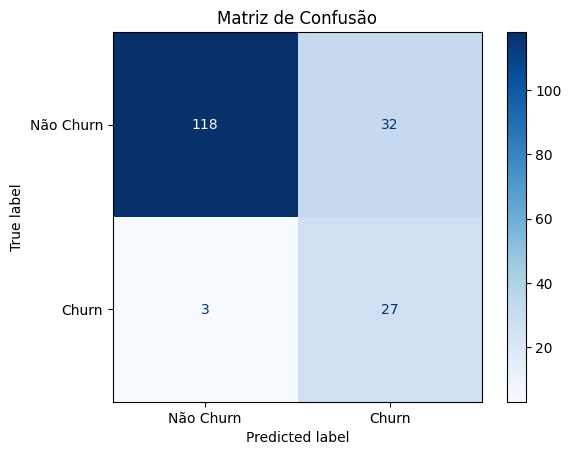

📊 Classification Report:

              precision    recall  f1-score   support

           0     0.9752    0.7867    0.8708       150
           1     0.4576    0.9000    0.6067        30

    accuracy                         0.8056       180
   macro avg     0.7164    0.8433    0.7388       180
weighted avg     0.8889    0.8056    0.8268       180



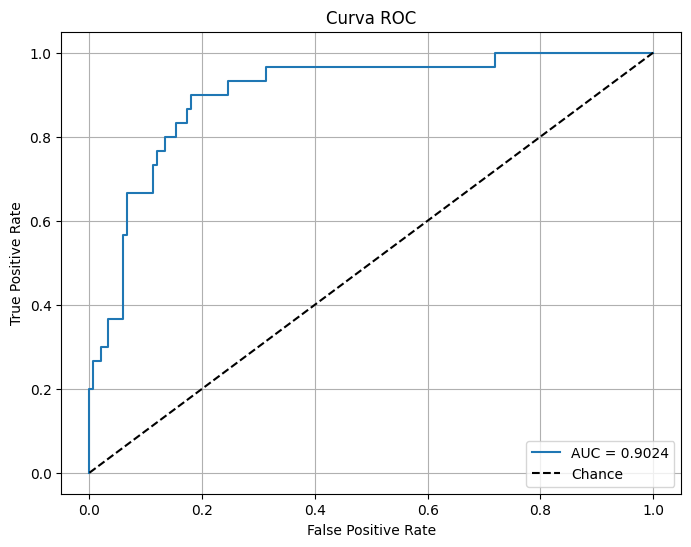

In [19]:

# Previsão
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]  # Probabilidade da classe positiva

# 1. Matriz de Confusão
plt.figure(figsize=(6, 4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["Não Churn", "Churn"], cmap="Blues", values_format='d')
plt.title("Matriz de Confusão")
plt.grid(False)
plt.show()

# 2. Métricas de Classificação
print("📊 Classification Report:\n")
print(classification_report(y_test, y_pred, digits=4))

# 3. Curva ROC e AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], 'k--', label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [25]:
model_file = models_path / "churn_pipeline_lr-l1-bsmote-scaled-binned-v1.joblib"

joblib.dump(pipeline, model_file)

['../models/churn_pipeline_lr-l1-bsmote-scaled-binned-v1.joblib']

In [27]:
pipeline_val = joblib.load(model_file)

In [28]:
# Previsões de classe e probabilidade
val_y_pred = pipeline_val.predict(X_test)
val_y_proba = pipeline_val.predict_proba(X_test)[:, 1]


📊 Classification Report (validação):
              precision    recall  f1-score   support

           0       0.98      0.79      0.87       150
           1       0.46      0.90      0.61        30

    accuracy                           0.81       180
   macro avg       0.72      0.84      0.74       180
weighted avg       0.89      0.81      0.83       180



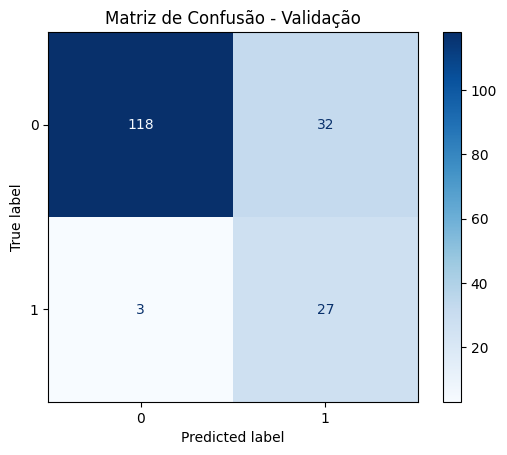

In [30]:

# Relatório de classificação
print("📊 Classification Report (validação):")
print(classification_report(y_test, val_y_pred))

# Matriz de confusão
val_cm = confusion_matrix(y_test, val_y_pred)
val_disp = ConfusionMatrixDisplay(confusion_matrix=val_cm)
val_disp.plot(cmap='Blues')
plt.title("Matriz de Confusão - Validação")
plt.show()



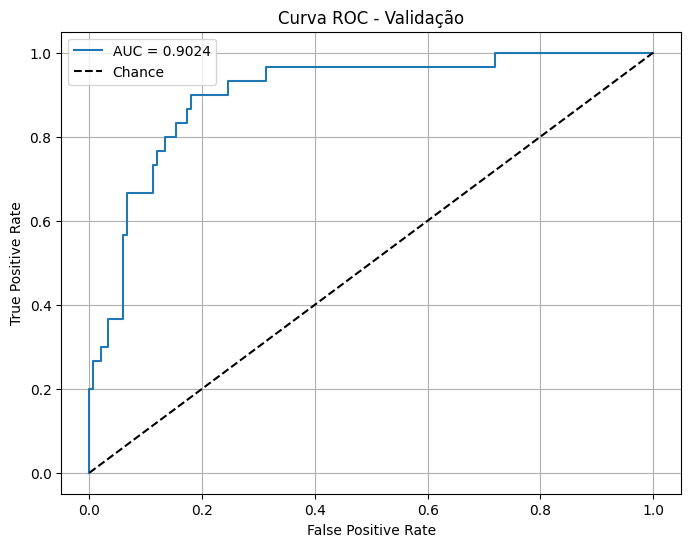

In [31]:
# Curva ROC
val_fpr, val_tpr, _ = roc_curve(y_test, val_y_proba)
val_roc_auc = roc_auc_score(y_test, val_y_proba)

plt.figure(figsize=(8, 6))
plt.plot(val_fpr, val_tpr, label=f'AUC = {val_roc_auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - Validação")
plt.legend()
plt.grid(True)
plt.show()